# Predicting Ethnicities, Age, and Gender with Neural Networks

## Table of Contents:
1. *Introduction*
2. *Data Preperation*
    * 2.1 Data Cleaning/Preparation
    * 2.2 Data Loading
    * 2.3 Data Exploration
    * 2.4 Data Preprocessing
3. *Model Architecture*
    * 3.1 Transfer Learning
    * 3.2 Neural Network Design
    * 3.3 Model Compilation
4. *Model Training*
    * 4.1 Training Process
    * 4.2 Model Evaluation and Improvement
    * 4.3 Transfer Learning
5. *Model Performance*
    * 5.1 Model Performance
    * 5.2 Confusion Matrix
    * 5.3 Model Prediction Graphing
6. *Model Deployment*
    * 6.1 Model Saving
7. *Conclusion*
8. *References*


## 1. Introduction:
In this notebook, we will explore the process of building a neural network model to predict ethnicities, age, and gender based on certain features. Predicting ethnicities, age, and gender can have various applications, including demographic analysis, social studies, and more. We will follow a step-by-step approach, covering data preprocessing, model architecture design, training, evaluation, and interpretation.

## 2. Data Preparation

### 2.1 Data Cleaning/Preparation

The dataset from FairFace is split between a training set and a validation set, lacking the test set. In this section, I will:
- Combine all the images into one folder
- Rename the images starting from 1 to the total number of images
- Compile all the csv files into one with the new names

In [1]:
import os
import shutil
import csv
import random
import cv2

In [2]:
# Moving the training images to the all images folder
temp_train_path = "C:\\Users\\mashe\\Downloads\\temp\\train"
all_images = "C:\\Users\\mashe\\Downloads\\temp\\all"

train_files = os.listdir(temp_train_path)

# Moving the training images to the all images folder
for file_name in train_files:
    train_path = os.path.join(temp_train_path, file_name)
    all_path = os.path.join(all_images, file_name)
    shutil.move(train_path, all_path)

In [3]:
# Moving the contents of the train csv to a general csv file
# Changing the file column to only include the name of the file
temp_train_csv = "C:\\Users\\mashe\\Downloads\\temp_csv\\train.csv"
general_csv = "C:\\Users\\mashe\\Downloads\\temp_csv\\all.csv"

# getting the data from the csv without the extra path on the filename
new_rows = []
with open(temp_train_csv, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        modified_row = [row[0].split('/')[-1]] + row[1:]
        new_rows.append(modified_row)

# writing the data back into the csv
with open(general_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(new_rows)

In [4]:
# Setting a variable for the name of the last image in train
img_num = len(os.listdir(all_images)) + 1
img_num

86745

Since the validation images and csv also start from 1, we will have to rename the images starting from the end of the training images, while also renaming the file column in the val csv file.

In [5]:
# Moving the validation images
temp_val_path = "C:\\Users\\mashe\\Downloads\\temp\\val"
all_images = "C:\\Users\\mashe\\Downloads\\temp\\all"
temp_val_csv = "C:\\Users\\mashe\\Downloads\\temp_csv\\val.csv"

# getting our images without the extra path
image_data = []
with open(temp_val_csv, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        modified_row = [row[0].split('/')[-1]] + row[1:]
        image_data.append(modified_row)

# get rid of the header row
image_data = image_data[1:]

# changing the name of the images and the csv data and moving them
for index, image in enumerate(image_data, start=img_num):
    new_image_name = str(index) + ".jpg"
    new_image_path = os.path.join(all_images, new_image_name)
    old_image_path = os.path.join(temp_val_path, image[0])
    shutil.move(old_image_path, new_image_path)

    for i, row in enumerate(image_data):
        if (row[0] == image[0]):
            image_data[i][0] = new_image_name
            break

# writing the new data into the csv file
with open(temp_val_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(image_data)

In [6]:
# Combining the val csv with the general csv
general_csv = "C:\\Users\\mashe\\Downloads\\temp_csv\\all.csv"
temp_val_csv = "C:\\Users\\mashe\\Downloads\\temp_csv\\val.csv"

# getting the data from general csv
rows = []
with open(general_csv, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        rows.append(row)

# adding the val data to the data we already have
with open(temp_val_csv, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        rows.append(row)

# writing the data to the general csv
with open(general_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)

### 2.2 Data Loading

Now that we've cleaned our data, we can start loading it in.

In [10]:
import pandas as pd

In [9]:
general_csv = "C:\\Users\\mashe\\Downloads\\all.csv"
df = pd.read_csv(general_csv)
df.head()

,file,age,gender,race,service_test
0,1.jpg,50-59,Male,East Asian,True
1,2.jpg,30-39,Female,Indian,False
2,3.jpg,3-9,Female,Black,False
3,4.jpg,20-29,Female,Indian,True
4,5.jpg,20-29,Female,Indian,True


### 2.3 Data Exploration

In [10]:
import matplotlib.pyplot as plt

In [11]:
df.describe()

,file,age,gender,race,service_test
count,97698,97698,97698,97698,97698
unique,97698,9,2,7,2
top,1.jpg,20-29,Male,White,False
freq,1,28898,51778,18612,52284


In [12]:
df.isna().any()

file            False
age             False
gender          False
race            False
service_test    False
dtype: bool

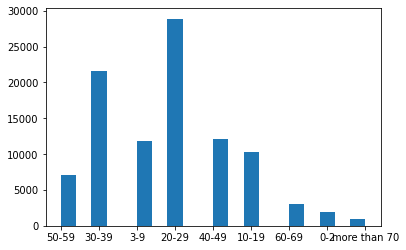

In [13]:
# graph distribution of ages
plt.hist(df['age'], bins=20)
plt.show()

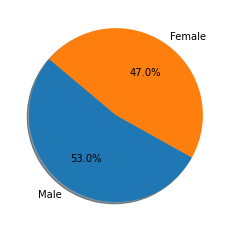

In [14]:
# Distribution of genders
labels = df['gender'].value_counts().index.tolist()
values = df['gender'].value_counts().values.tolist()

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

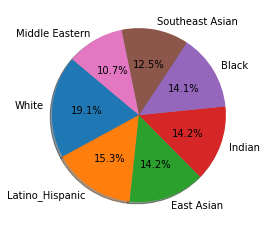

In [15]:
# race distribution
labels = df['race'].value_counts().index.tolist()
values = df['race'].value_counts().values.tolist()

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

Evenly distributed races and genders! 

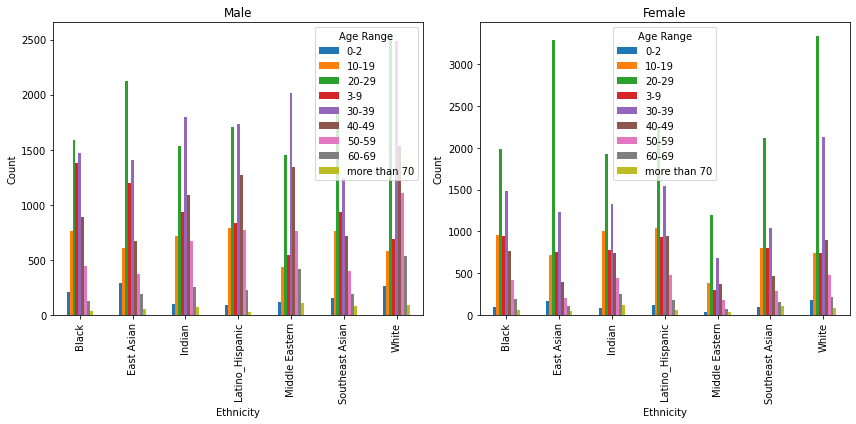

In [16]:
# Group data by gender, ethnicity, and age_range
grouped = df.groupby(['gender', 'race', 'age']).size().unstack().fillna(0)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

grouped.loc['Male'].plot(kind='bar', ax=axes[0], title='Male')
grouped.loc['Female'].plot(kind='bar', ax=axes[1], title='Female')

for ax in axes:
    ax.set_xlabel('Ethnicity')
    ax.set_ylabel('Count')
    ax.legend(title='Age Range')

plt.tight_layout()
plt.show()

In [28]:
df['age'].describe()

count     97698
unique        9
top       20-29
freq      28898
Name: age, dtype: object

In [18]:
df['race'].describe()

count     97698
unique        7
top       White
freq      18612
Name: race, dtype: object

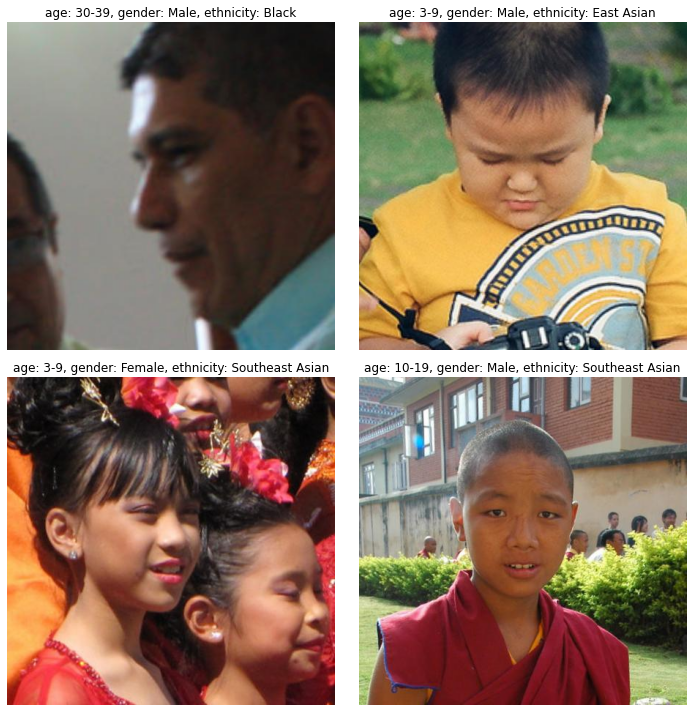

In [19]:
# Graphing example images
import random
image_source = "C:\\Users\\mashe\\Downloads\\all"
plt.figure(figsize=(10,10))
for i in range(4):
    
    ax = plt.subplot(2, 2, i+1)
    rand = random.randint(0, len(df)-1)

    img = df.iloc[rand, 0]
    age = df.iloc[rand, 1]
    gender = df.iloc[rand, 2]
    ethnicity = df.iloc[rand, 3]
    
    # Construct image path
    image_path = os.path.join(image_source, img)
    
    # Read and display the image
    img_data = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title(f"age: {age}, gender: {gender}, ethnicity: {ethnicity}")
    plt.axis('off')  # Turn off axis
    
plt.tight_layout()
plt.show()

### 2.4 Data Preprocessing

First, we will combine Southeast Asian and East Asian into one Asian category, since we want the model to be accurate in predicting general ethnicities.

In [34]:
idx = df[(df['race'] == 'East Asian') | (df['race'] == 'Southeast Asian')].index
df.loc[idx, 'race'] = 'Asian'
df['race'].value_counts()

Asian              26047
White              18612
Latino_Hispanic    14990
Indian             13835
Black              13789
Middle Eastern     10425
Name: race, dtype: int64

In [35]:
df.to_csv("C:\\Users\\mashe\\Downloads\\all.csv", index=False)

We now need to split the images and csv into a 70-15-15 split for training, validation, and testing data.

In [36]:
image_source = "C:\\Users\\mashe\\Downloads\\all"
csv_source = "C:\\Users\\mashe\\Downloads\\all.csv"
image_destination = "C:\\Users\\mashe\\Downloads\\images"
csv_destination = "C:\\Users\\mashe\\Downloads\\csv"

# creating the directories
splits = ["train", "val", "test"]
for split in splits:
    os.mkdir(os.path.join(image_destination, split))

# getting the data from the csv file
csv_data = []
header = []
with open(csv_source, 'r') as csvfile:
    reader = csv.reader(csvfile)
    header = reader.__next__() # getting the header and skipping it
    for row in reader:
        csv_data.append(row)

random.shuffle(csv_data)

# splitting the data into train, val, test
total_images = len(csv_data)
train_size = int(0.70*total_images)
val_size = int(0.15*total_images)

train_data = csv_data[ : train_size]
val_data = csv_data[train_size : train_size + val_size]
test_data = csv_data[train_size + val_size : ]

# moving the images and creating the csv files
for split, data in zip(splits, [train_data, val_data, test_data]):
    for row in data:
        image_path = os.path.join(image_source, row[0])
        split_destination = os.path.join(image_destination, split)
        shutil.move(image_path, split_destination)

    csv_path = os.path.join(csv_destination, split + ".csv")
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        for row in data:
            modified_row = [os.path.join(split, row[0])] + row[1:]
            writer.writerow(modified_row)

In [3]:
# making sure the data was moved properly
train_dir = "C:\\Users\\mashe\\Downloads\\images\\train"
val_dir = "C:\\Users\\mashe\\Downloads\\images\\val"
test_dir = "C:\\Users\\mashe\\Downloads\\images\\test"
train_csv = "C:\\Users\\mashe\\Downloads\\csv\\train.csv"
val_csv = "C:\\Users\\mashe\\Downloads\\csv\\val.csv"
test_csv = "C:\\Users\\mashe\\Downloads\\csv\\test.csv"

train_len = len(os.listdir(train_dir))
val_len = len(os.listdir(val_dir))
test_len = len(os.listdir(test_dir))

print(train_len, val_len, test_len)
print(train_len + val_len + test_len)

counter = 0
with open(train_csv, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        counter += 1
print(counter)

counter1 = 0
with open(val_csv, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        counter1 += 1
print(counter1)

counter2 = 0
with open(test_csv, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        counter2 += 1
print(counter2)

print(counter + counter1 + counter2)

68388 14654 14656
97698
68388
14654
14656
97698


In [4]:
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

In [39]:
train_df.head()

,file,age,gender,race,service_test
0,train\50168.jpg,40-49,Female,Latino_Hispanic,False
1,train\95687.jpg,50-59,Female,Black,False
2,train\84703.jpg,40-49,Male,White,False
3,train\72800.jpg,20-29,Female,White,False
4,train\31856.jpg,20-29,Male,Asian,True


In [40]:
val_df.head()

,file,age,gender,race,service_test
0,val\28355.jpg,30-39,Male,Latino_Hispanic,False
1,val\35965.jpg,10-19,Female,Asian,True
2,val\60181.jpg,20-29,Female,Asian,True
3,val\54378.jpg,20-29,Female,White,False
4,val\24666.jpg,30-39,Female,Latino_Hispanic,False


In [41]:
test_df.head()

,file,age,gender,race,service_test
0,test\73262.jpg,20-29,Female,Latino_Hispanic,True
1,test\27551.jpg,3-9,Male,Asian,True
2,test\72312.jpg,10-19,Female,Black,False
3,test\47354.jpg,3-9,Male,White,False
4,test\66943.jpg,3-9,Female,White,False


Now we will use the dlib library to detect and crop the faces, and store these cropped faces for training, validation, and testing later on.

In [32]:
import dlib
import cv2
import os
import pandas as pd
import csv
import concurrent.futures

In [5]:
face_detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(".\\dlib_models\\shape_predictor_5_face_landmarks.dat")
face_detector, sp

(<_dlib_pybind11.fhog_object_detector at 0x1ca28f45070>,
 <_dlib_pybind11.shape_predictor at 0x1ca2a75e6b0>)

Creating a function to detect a face, crop the face, and save the face to a folder.

In [36]:
def crop_face_and_save(image_name, image_path, output_folder):
    # Load the image
    img = dlib.load_rgb_image(image_path)

    # Detect faces
    dets = face_detector(img, 0)
    if len(dets) == 0:
        return
    
    # Find the 5 face landmarks we need to do the alignment.
    faces = dlib.full_object_detections()
    for detection in dets:
        faces.append(sp(img, detection))

    # Get the aligned face images
    images = dlib.get_face_chips(img, faces, size=320, padding=0.25)
    for image in images:
        file_path = os.path.join(output_folder, image_name)
        dlib.save_image(image, file_path)

In [27]:
image_source = "C:\\Users\\mashe\\Downloads\\images"
image_destination = "C:\\Users\\mashe\\Downloads\\cropped_images"

Looping through the training, validation and test images using the csv's to crop the images and save them.

In [28]:
train_files = train_df["file"]
val_files = val_df["file"]
test_files = test_df["file"]

In [29]:
def process_image(image):
    image_path = os.path.join(image_source, image)
    check_cropped = os.path.join(image_destination, image)
    if os.path.exists(check_cropped):
        pass #image is already cropped
    else:
        crop_face_and_save(image, image_path, image_destination)

Using parallel processing to compute the images faster

In [38]:
with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
    executor.map(process_image, train_files)

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
    executor.map(process_image, val_files)

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
    executor.map(process_image, test_files)

Now that we have detected and cropped most faces, we will find and remove the faces that weren't cropped from our dataframes since they are not useful for our model.

In [39]:
cropped_images = "C:\\Users\\mashe\\Downloads\\cropped_images"

In [40]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

68388
14654
14656


In [41]:
# Create a function that'll clean the dataframes
def clean_df(df, df_file_column):
    for image in df_file_column:
        image_path = os.path.join(cropped_images, image)
        if not os.path.exists(image_path):
            df.drop(df[df['file'] == image].index, inplace=True)

In [42]:
clean_df(train_df, train_df['file'])
clean_df(val_df, val_df['file'])
clean_df(test_df, test_df['file'])

In [43]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

57412
12218
12359


The number may have dropped drastically... but this just means we got rid of faces that aren't properly recognizable!

In [44]:
# lets replace the old csv files with the new adjusted dataframes
train_df.to_csv("C:\\Users\\mashe\\Downloads\\csv\\train.csv", index=False)
val_df.to_csv("C:\\Users\\mashe\\Downloads\\csv\\val.csv", index=False)
test_df.to_csv("C:\\Users\\mashe\\Downloads\\csv\\test.csv", index=False)

Now that we have our csv and cropped images, we can begin to prepare our data for training by converting the images and labels in each set into numerical data we can use for the model.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
# Turning the training, validation, and testing sets into dataframes
data_dir = "C:\\Users\\mashe\\Downloads\\cropped_images"

train_csv = "C:\\Users\\mashe\\Downloads\\csv\\train.csv"
val_csv = "C:\\Users\\mashe\\Downloads\\csv\\val.csv"
test_csv = "C:\\Users\\mashe\\Downloads\\csv\\test.csv"

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

batch_size=32
img_size=(224, 224)
input_shape = (224, 224, 3)

print("Training set size: ", len(train_df))
print("Validation set size: ", len(val_df))
print("Testing set size: ", len(test_df))

Training set size:  57412
Validation set size:  12218
Testing set size:  12359


In [3]:
train_df.head()

,file,age,gender,race,service_test
0,train\50168.jpg,40-49,Female,Latino_Hispanic,False
1,train\95687.jpg,50-59,Female,Black,False
2,train\84703.jpg,40-49,Male,White,False
3,train\72800.jpg,20-29,Female,White,False
4,train\31856.jpg,20-29,Male,Asian,True


To numerically encode our data for our neural network to process it better, lets:
- turn our age ranges into a range from 0 to 9
- encode our genders to binary values
- turn our races into a range from 0 to 6

The reason for turning these values into ranges, is so that the model can easily interpret patterns with these values, and not have to deal with the complexity of the actual values.

When we get our predictions, we can then turn these ranges back into their original values.

In [4]:
# first we need to turn our ages into a number, so we'll just get the average age
def convert_age_range(age_range):
    if age_range == '0-2':
        return 0.
    if age_range == '3-9':
        return 1.
    if age_range == '10-19':
        return 2.
    if age_range == '20-29':
        return 3.
    if age_range == '30-39':
        return 4.
    if age_range == '40-49':
        return 5.
    if age_range == '50-59':
        return 6.
    if age_range == '60-69':
        return 7.
    if age_range == 'more than 70':
        return 8.

In [5]:
train_df['age'] = train_df['age'].apply(convert_age_range)
val_df['age'] = val_df['age'].apply(convert_age_range)
test_df['age'] = test_df['age'].apply(convert_age_range)

* 0 = 0-2
* 1 = 3-9
* 2 = 10-19
* 3 = 20-29
* 4 = 30-39
* 5 = 40-49
* 6 = 50-59
* 7 = 60-69
* 8 = more than 70

In [6]:
# turning our genders into binary values
train_df['gender'] = (train_df['gender'] == 'Male').astype(float)
val_df['gender'] = (val_df['gender'] == 'Male').astype(float)
test_df['gender'] = (test_df['gender'] == 'Male').astype(float)

In [7]:
# Turning our races into numerical values
train_df.loc[train_df['race'] == "White", 'race'] = 0.
train_df.loc[train_df['race'] == "Black", 'race'] = 1.
train_df.loc[train_df['race'] == "Latino_Hispanic", 'race'] = 2.
train_df.loc[train_df['race'] == "Asian", 'race'] = 3.
train_df.loc[train_df['race'] == "Indian", 'race'] = 4.
train_df.loc[train_df['race'] == "Middle Eastern", 'race'] = 5.

val_df.loc[val_df['race'] == "White", 'race'] = 0.
val_df.loc[val_df['race'] == "Black", 'race'] = 1
val_df.loc[val_df['race'] == "Latino_Hispanic", 'race'] = 2.
val_df.loc[val_df['race'] == "Asian", 'race'] = 3.
val_df.loc[val_df['race'] == "Indian", 'race'] = 4.
val_df.loc[val_df['race'] == "Middle Eastern", 'race'] = 5.

test_df.loc[test_df['race'] == "White", 'race'] = 0.
test_df.loc[test_df['race'] == "Black", 'race'] = 1.
test_df.loc[test_df['race'] == "Latino_Hispanic", 'race'] = 2.
test_df.loc[test_df['race'] == "Asian", 'race'] = 3.
test_df.loc[test_df['race'] == "Indian", 'race'] = 4.
test_df.loc[test_df['race'] == "Middle Eastern", 'race'] = 5.

* 0 = White
* 1 = Black
* 2 = Latino_Hispanic
* 3 = Asian
* 4 = Indian
* 5 = Middle Eastern

In [8]:
train_df.head()

,file,age,gender,race,service_test
0,train\50168.jpg,5.0,0.0,2.0,False
1,train\95687.jpg,6.0,0.0,1.0,False
2,train\84703.jpg,5.0,1.0,0.0,False
3,train\72800.jpg,3.0,0.0,0.0,False
4,train\31856.jpg,3.0,1.0,3.0,True


Our data has been transformed into numerical categories, making it easier for our model to process. We can now move on to building our model and data generators.

In [9]:
# Creating data generators for data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# we use the general directory, since each dataframe has a relative path to the image from this directory
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir, 
    x_col='file',
    y_col=['age', 'gender', 'race'],
    target_size=img_size,
    batch_size=batch_size,
    class_mode='multi_output',
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_dir,
    x_col='file',
    y_col=['age', 'gender', 'race'],
    target_size=img_size,
    batch_size=batch_size,
    class_mode='multi_output',
)

Found 57412 validated image filenames.
Found 12218 validated image filenames.


## 3. Model Architecture

### 3.1 Neural Network Design

In [64]:
# set random seed
tf.random.set_seed(42)

# Creating the model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Separate branches for age, race, and gender
age_output = Dense(9, activation='softmax', name='age')(model.layers[-1].output)
gender_output = Dense(2, activation='sigmoid', name='gender')(model.layers[-1].output)
race_output = Dense(6, activation='softmax', name='race')(model.layers[-1].output)

# Create a new model with the inputs and the combined outputs
ethnivision_model = Model(inputs=model.input, outputs=[age_output, gender_output, race_output])

### 3.2 Model Compilation

In [65]:
# defining loss functions for each output
losses = {
    'age': 'sparse_categorical_crossentropy',
    'gender': 'sparse_categorical_crossentropy',
    'race': 'sparse_categorical_crossentropy'
}

# Compiling the model
ethnivision_model.compile(
    loss=losses,
    optimizer=Adam(),
    metrics=['accuracy']
)

In [66]:
ethnivision_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['conv2d_input[0][0]']        
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d[0][0]']   

## 4. Model Training

### 4.1 Training Process

In [18]:
history = ethnivision_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
2125/2125 [==============================] - 1459s 686ms/step - loss: 4.3787 - age_loss: 1.8490 - gender_loss: 0.6690 - race_loss: 1.8607 - age_accuracy: 0.2941 - gender_accuracy: 0.5898 - race_accuracy: 0.2516 - val_loss: 4.1006 - val_age_loss: 1.7569 - val_gender_loss: 0.6139 - val_race_loss: 1.7299 - val_age_accuracy: 0.3225 - val_gender_accuracy: 0.6496 - val_race_accuracy: 0.3274
Epoch 2/10
2125/2125 [==============================] - 2265s 1s/step - loss: 4.0808 - age_loss: 1.7266 - gender_loss: 0.6205 - race_loss: 1.7337 - age_accuracy: 0.3343 - gender_accuracy: 0.6484 - race_accuracy: 0.3178 - val_loss: 3.7552 - val_age_loss: 1.6311 - val_gender_loss: 0.5324 - val_race_loss: 1.5917 - val_age_accuracy: 0.3558 - val_gender_accuracy: 0.7257 - val_race_accuracy: 0.3804
Epoch 3/10
2125/2125 [==============================] - 1302s 613ms/step - loss: 3.8538 - age_loss: 1.6430 - gender_loss: 0.5680 - race_loss: 1.6428 - age_accuracy: 0.3525 - gender_accuracy: 0.6980 - race_

### 4.2 Model Evaluation and Improvement

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=data_dir,
    x_col="file",
    y_col=['age', 'gender', 'race'],
    target_size=img_size,
    batch_size=batch_size,
    class_mode='multi_output',
)

Found 14559 validated image filenames.


In [25]:
test_loss, age_loss, gender_loss, race_loss, test_accuracy_age, test_accuracy_gender, test_accuracy_race = ethnivision_model.evaluate(test_generator)
print(f"Test accuracy (Age): {test_accuracy_age}")
print(f"Test accuracy (Gender): {test_accuracy_gender}")
print(f"Test accuracy (Race): {test_accuracy_race}")

455/455 [==============================] - 43s 94ms/step - loss: 3.8143 - age_loss: 1.6462 - gender_loss: 0.5572 - race_loss: 1.6109 - age_accuracy: 0.3570 - gender_accuracy: 0.7014 - race_accuracy: 0.3818
Test accuracy (Age): 0.35696133971214294
Test accuracy (Gender): 0.7014217972755432
Test accuracy (Race): 0.381756991147995


Not the best... Time to improve our model.

In [51]:
# Finding the ideal learning rate
tf.random.set_seed(42)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

age_output = Dense(9, activation='softmax', name='age')(model.layers[-1].output)
gender_output = Dense(2, activation='sigmoid', name='gender')(model.layers[-1].output)
race_output = Dense(6, activation='softmax', name='race')(model.layers[-1].output)

ethnivision_model = Model(inputs=model.input, outputs=[age_output, gender_output, race_output])

losses = {
    'age': 'sparse_categorical_crossentropy',
    'gender': 'sparse_categorical_crossentropy',
    'race': 'sparse_categorical_crossentropy'
}

ethnivision_model.compile(
    loss=losses,
    optimizer=Adam(),
    metrics=['accuracy']
)

lr_scheduler = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

history = ethnivision_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[lr_scheduler],
    verbose=0
)

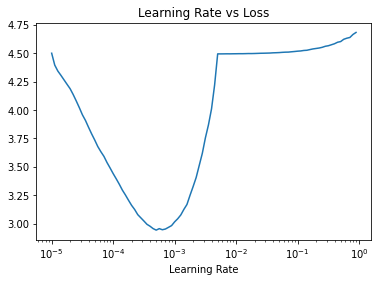

In [85]:
#plot the learning rate vs loss
lrs = 1e-5 * (10 ** (tf.range(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.title("Learning Rate vs Loss")
plt.show()
#ideal learning rate is the point where the loss decreases the fastest

The loss decreases fastest around 1e-4, so we will use that as our learning rate.

### 4.3 Transfer Learning

We're going to use the VGG16 model as a base for our model, and add our own layers on top of it. This way our model already has a good understanding of the features of a face, and we can train it to understand the features that we are interested in.

In [10]:
model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [11]:
# Freeze the layers so they don't get updated during training
for layer in model.layers:
    layer.trainable = False

In [13]:
# Creating our new model
tf.random.set_seed(42)

# Building seperate branches for each output

age_output = Flatten()(model.layers[-1].output)
age_output = Dense(256, activation='relu')(age_output)
age_output = BatchNormalization()(age_output)
age_output = Dropout(0.5)(age_output)
age_output = Dense(9, activation='softmax', name='age')(age_output)

gender_output = Flatten()(model.layers[-1].output)
gender_output = Dense(256, activation='relu')(gender_output)
gender_output = BatchNormalization()(gender_output)
gender_output = Dropout(0.5)(gender_output)
gender_output = Dense(2, activation='sigmoid', name='gender')(gender_output)

race_output = Flatten()(model.layers[-1].output)
race_output = Dense(256, activation='relu')(race_output)
race_output = Dense(128, activation='relu')(race_output)
race_output = BatchNormalization()(race_output)
race_output = Dropout(0.5)(race_output)
race_output = Dense(6, activation='softmax', name='race')(race_output)

ethnivision_model = Model(inputs=model.input, outputs=[age_output, gender_output, race_output], name='ethnivision')

losses = {
    'age': 'sparse_categorical_crossentropy',
    'gender': 'sparse_categorical_crossentropy',
    'race': 'sparse_categorical_crossentropy'
}

loss_weights = {
    'age': 2,
    'gender': 0.2,
    'race': 3.5
}

learning_rate = 1e-4
epochs = 30

ethnivision_model.compile(
    loss=losses,
    loss_weights=loss_weights,
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss', save_best_only=True)
]

history = ethnivision_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/30
 724/1795 [===========>..................] - ETA: 52:48 - loss: 11.8867 - age_loss: 2.4019 - gender_loss: 0.8188 - race_loss: 1.9769 - age_accuracy: 0.2138 - gender_accuracy: 0.6143 - race_accuracy: 0.2607

After many experiments, this is the best model created so far.

In [ ]:
plot_model(ethnivision_model, show_shapes=True, show_layer_names=True)

## 5. Model Performance

### 5.1 Model Performance

In [ ]:
# Plotting the training history of the model
pd.DataFrame(history.history).plot(figsize=(8, 5), title="Model Training History")

In [ ]:
test_loss, age_loss, gender_loss, race_loss, test_accuracy_age, test_accuracy_gender, test_accuracy_race = ethnivision_model.evaluate(test_generator)
print(f"Test accuracy (Age): {test_accuracy_age}")
print(f"Test accuracy (Gender): {test_accuracy_gender}")
print(f"Test accuracy (Race): {test_accuracy_race}")

In [ ]:
#using classification evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# make predictions
y_preds = ethnivision_model.predict(test_generator)

y_preds = ethnivision_model.predict_generator(test_generator)
predicted_classes = convert_to_class(y_preds)

# get y_true
y_true = test_generator.classes

In [ ]:
#classification report
classification_report(y_true, y_preds)

### 5.2 Confusion Matrix

In [ ]:
# remix of sci-kit learns plot_confusion_matrix
# https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.plot_confusion_matrix.html
def create_confusion_matrix(y_preds, y_true, classes=None):
    import itertools
    figsize = (10, 10)

    # create the confusion matrix
    cm = confusion_matrix(y_true, y_preds)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] #normalize our confusion matrix
    n_classes = cm.shape[0] #gets the number of classes

    # prettify the matrix
    fig, ax = plt.subplots(figsize=figsize)

    # create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # create classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # label the axises
    ax.set(
        title="Confusion matrix",
        xlabel="predicted label",
        ylabel="true label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
        )

    # set threshold for different colours
    threshold = (cm.max() + cm.min()) / 2

    # plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
        horizontalalignment="center",
        color="white" if cm[i, j] > threshold else "black",
        size=15)

In [ ]:
age_list = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]
gender_list = ["Male", "Female"]
race_list = ["White", "Black", "Latino_Hispanic", "East Asian", "Southeast Asian", "Indian", "Middle Eastern"]

In [ ]:
# create a confusion matrix for age, race, and gender


### 5.3 Model Prediction Graphing

In [ ]:
# plot a random image and the prediction/truth
import random
def plot_random_image(model, generator, classes):
    """
    Picks a random image, plots it and labels it with prediction and truth label
    """

    # change this function to predict with test generator

    # set up random integer
    i = random.randint(0, len(images))
    # create predictions and targets
    target_image = images[i]
    pred_probs = model.predict(target_image.reshape(1, 28, 28))
    # need to reshape because we predict on array of images
    pred_label = classes[pred_probs.argmax()]
    true_label = classes[true_labels[i]]
    # plot the image
    plt.imshow(target_image, cmap=plt.cm.binary)
    # change the color of the titles depending on if the prediction is right or wrong
    if (pred_label == true_label):
        color = "green"
    else:
        color = "red"
    # add xlabel information(prediction/true label)
    plt.xlabel("pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                    100*tf.reduce_max(pred_probs),
                                                    true_label),
                                                    color=color)

In [ ]:
plot_random_image(ethnivision_model, test_generator, class_names)

## 6. Model Deployment

### 6.1 Model Saving

In [ ]:
ethnivision_model.save('models')

## 7. Conclusion

In this notebook, we successfully developed a machine learning model for ethnicity, age, and gender predictions from facial images. Key highlights include:

- Thoughtful data collection and preprocessing contributed to model accuracy.
- Convolutional Neural Networks effectively captured facial features.
- Rigorous validation and testing ensured reliable performance.
- The model was seamlessly integrated into our full-stack website.
- Opportunities for ongoing improvement and expansion remain.

If you made it this far, thanks for joining me on this journey exploring the power of modern machine learning API's and frameworks.

Many errors were made(spending 4 hours of debugging only to see I put one label infront of the other on accident), but the struggles make us better in the end. I hope you enjoyed it as much as I did!

## 8. References

The dataset was retrieved from the FairFace study.

Karkkainen, Kimmo and Joo, Jungseock. (2021). FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age for Bias Measurement and Mitigation. Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision. 1548-1558. 10.1109/WACV48630.2021.00159